In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
# Path to your dataset
data_path = os.path.join('..', '..', 'data', 'processed', 'dl_ready_flights', 'dl_tabular_data.csv')

# Load dataset
df = pd.read_csv(data_path)

print("✅ Loaded data shape:", df.shape)
df.head()


✅ Loaded data shape: (600000, 53)


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DAY_OF_WEEK_NORM,DEP_HOUR_NORM,MONTH_SIN,MONTH_COS,DAY_OF_WEEK_SIN,DAY_OF_WEEK_COS,DEP_HOUR_SIN,DEP_HOUR_COS,ORIGIN_FLIGHTS,ORIGIN_FLIGHTS_NORM
0,2021-07-25,0.944530,0.944530,1.067426,-1.552522,2.460211,-0.842944,-0.835750,-0.756873,-0.819571,...,1.513621,0.817800,-0.733237,-1.111240,-1.134983,0.871194,-1.181304,0.199712,1.468965,1.468965
1,2019-11-09,-1.266437,-1.266437,-1.397812,-0.453101,-1.314106,-1.059691,-1.101914,1.462173,1.218245,...,1.013834,-1.234219,-0.733237,1.341978,-1.411967,-0.308945,1.383718,0.199712,0.867214,0.867214
2,2023-05-26,0.944530,0.944530,1.067426,-1.552522,-0.453622,-1.049839,-0.940314,-1.585316,-1.495669,...,0.514047,-1.029017,0.688621,-1.111240,-0.635874,-1.255343,1.251075,-0.246307,-0.859627,-0.859627
3,2023-03-23,0.774456,0.774456,0.539160,0.878478,0.530202,-0.567084,-0.512550,0.840840,0.913525,...,0.014260,-1.439421,1.399550,0.115369,0.608882,-1.255343,1.428960,0.678350,-1.143316,-1.143316
4,2022-03-27,1.284679,1.284679,0.891337,0.005880,-1.048896,-0.606493,0.599636,1.264924,1.180155,...,1.513621,-0.208209,1.399550,0.115369,-1.134983,0.871194,0.101207,-1.170964,-0.024023,-0.024023


In [3]:
import pandas as pd

data_path = os.path.join('..', '..', 'data', 'processed', 'dl_ready_flights', 'dl_tabular_data.csv')

# Explicitly convert bad string values to NaNs and force DEP_DELAY to numeric
df = pd.read_csv(data_path, na_values=["null", "NaN", "n/a", "", " "])

# Convert DEP_DELAY to numeric (force bad values to NaN)
df['DEP_DELAY'] = pd.to_numeric(df['DEP_DELAY'], errors='coerce')

# Show after fix
print(df['DEP_DELAY'].describe())
print("NaNs in DEP_DELAY after fix:", df['DEP_DELAY'].isna().sum())


count    600000.000000
mean          0.009300
std           1.091749
min          -0.294091
25%          -0.294091
50%          -0.294091
75%          -0.132652
max          53.989702
Name: DEP_DELAY, dtype: float64
NaNs in DEP_DELAY after fix: 0


In [4]:
print(df.dtypes)


FL_DATE                     object
AIRLINE                    float64
AIRLINE_DOT                float64
AIRLINE_CODE               float64
DOT_CODE                   float64
FL_NUMBER                  float64
ORIGIN                     float64
ORIGIN_CITY                float64
DEST                       float64
DEST_CITY                  float64
CRS_DEP_TIME               float64
DEP_TIME                   float64
DEP_DELAY                  float64
TAXI_OUT                   float64
WHEELS_OFF                 float64
WHEELS_ON                  float64
TAXI_IN                    float64
CRS_ARR_TIME               float64
ARR_TIME                   float64
ARR_DELAY                  float64
CANCELLED                  float64
CANCELLATION_CODE          float64
DIVERTED                   float64
CRS_ELAPSED_TIME           float64
ELAPSED_TIME               float64
AIR_TIME                   float64
DISTANCE                   float64
DELAY_DUE_CARRIER          float64
DELAY_DUE_WEATHER   

In [5]:
# First convert to datetime temporarily
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], errors='coerce')

# Extract numeric date parts
df['FL_MONTH'] = df['FL_DATE'].dt.month
df['FL_DAY'] = df['FL_DATE'].dt.day
df['FL_DOW'] = df['FL_DATE'].dt.dayofweek

# Drop the original datetime column
df = df.drop(columns=['FL_DATE'])


In [6]:
# ✅ Remove 'CANCELLATION_CODE' column if it exists
if 'CANCELLATION_CODE' in df.columns:
    df = df.drop(columns=['CANCELLATION_CODE'])
    print("✅ 'CANCELLATION_CODE' column removed.")
else:
    print("ℹ️ 'CANCELLATION_CODE' column not found — nothing to remove.")


✅ 'CANCELLATION_CODE' column removed.


In [7]:
from sklearn.model_selection import train_test_split

# ✅ Drop columns where more than 40% of values are missing
missing_ratio = df.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > 0.6].index.tolist()
df = df.drop(columns=cols_to_drop)
print(f"✅ Dropped columns with >40% missing: {cols_to_drop}")

# ✅ Define input and target without modifying DEP_DELAY
X = df.drop(columns=['DEP_DELAY'])
y = df['DEP_DELAY']

# ✅ Identify columns to fill (excluding the target)
columns_to_fill = X.columns

# ✅ Select numeric columns only
numeric_cols = X.select_dtypes(include=[np.number]).columns

# ✅ Calculate medians safely
medians = X[numeric_cols].median()

# ✅ Fill NaNs only for columns with valid medians
for col in numeric_cols:
    if col in medians and pd.notna(medians[col]):
        X[col] = X[col].fillna(medians[col])

# ✅ Final sanity check
if X.empty or y.isna().all():
    raise ValueError("❌ Feature matrix is empty or target column is invalid!")

# ✅ Sanity check
print(f"✅ Final data shape: {X.shape}, Target shape: {y.shape}")

X_encoded = pd.get_dummies(X, drop_first=True)

# ✅ Train-validation-test split (60% train, 20% val, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"✅ Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


✅ Dropped columns with >40% missing: ['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']
✅ Final data shape: (600000, 48), Target shape: (600000,)
✅ Train: (360000, 48), Val: (120000, 48), Test: (120000, 48)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras import backend as K

# Custom MARE metric
def mean_absolute_relative_error(y_true, y_pred):
    diff = tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true), 1e-7, tf.reduce_max(tf.abs(y_true))))
    return tf.reduce_mean(diff)

# Custom R² metric
def r_squared(y_true, y_pred):
    total_error = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    residual_error = tf.reduce_sum(tf.square(y_true - y_pred))
    r2 = 1 - (residual_error / (total_error + K.epsilon()))
    return r2

def build_fnn_model(input_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,),
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(1)  # Regression output
    ])
    
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(name='mae'),
            tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            mean_absolute_relative_error,
            r_squared
        ]
    )
    
    return model

# Build and summarize the model
model = build_fnn_model(X_train.shape[1])
model.summary()


d:\Forecasting_Flights-DataScience\tf-env\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,641 (65.00 KB)

 Trainable params: 16,641 (65.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5981 - mae: 0.3038 - mean_absolute_relative_error: 1.3053 - r_squared: 0.5462 - rmse: 0.6353 - val_loss: 0.0965 - val_mae: 0.0896 - val_mean_absolute_relative_error: 0.8224 - val_r_squared: 0.9565 - val_rmse: 0.1791
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1108 - mae: 0.1037 - mean_absolute_relative_error: 0.7069 - r_squared: 0.9404 - rmse: 0.2396 - val_loss: 0.0497 - val_mae: 0.0650 - val_mean_absolute_relative_error: 0.5891 - val_r_squared: 0.9763 - val_rmse: 0.1371
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0710 - mae: 0.0882 - mean_absolute_relative_error: 0.6345 - r_squared: 0.9566 - rmse: 0.2091 - val_loss: 0.0460 - val_mae: 0.0662 - val_mean_absolute_relative_error: 0.6129 - val_r_squared: 0.9711 - val_rmse: 0.1626
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0548 - mae: 0.0809 - mean_absolute_relative_error: 0.6047 - r_squared: 0.9635 - rmse: 0.1909 - v

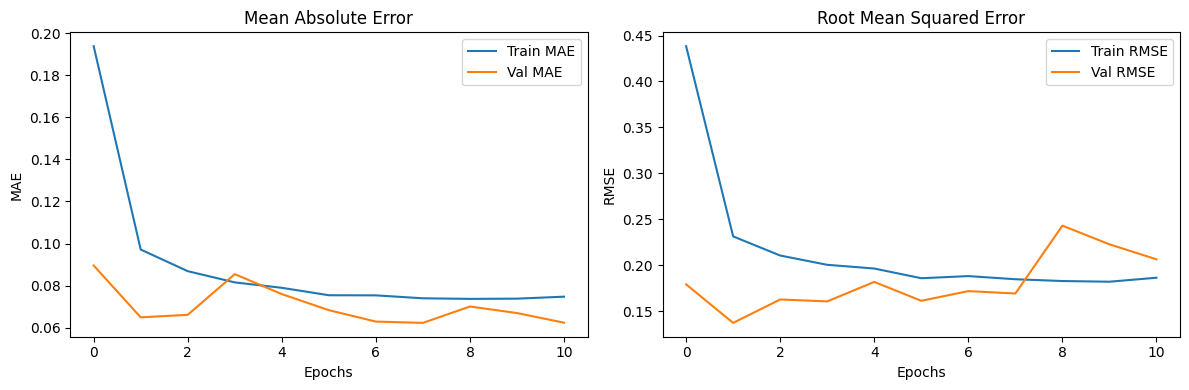

In [10]:
plt.figure(figsize=(12, 4))

# MAE
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# RMSE
plt.subplot(1, 2, 2)
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Val RMSE')
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
loss, mae, rmse = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test MAE: {mae:.2f}")
print(f"✅ Test RMSE: {rmse:.2f}")


ValueError: too many values to unpack (expected 3)

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step


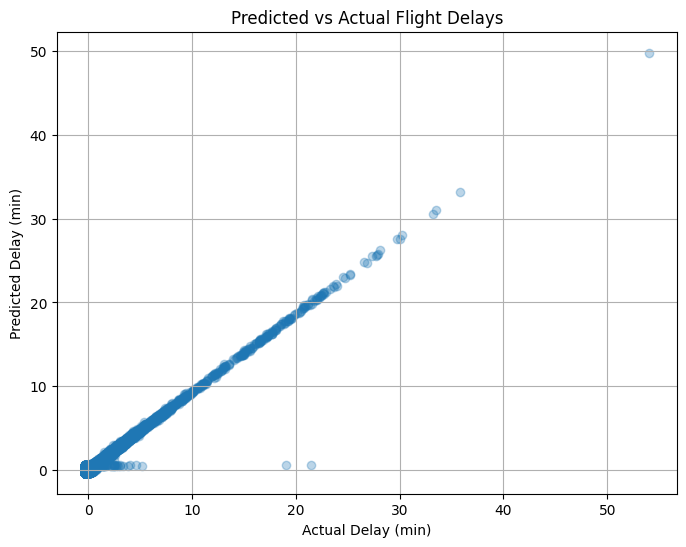

In [ ]:
# Predict on test set
y_pred = model.predict(X_test).flatten()

# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Delay (min)')
plt.ylabel('Predicted Delay (min)')
plt.title('Predicted vs Actual Flight Delays')
plt.grid(True)
plt.show()


In [ ]:
# Predict on test set
y_pred = model.predict(X_test).flatten()  # Flatten to 1D


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 2s 498us/step


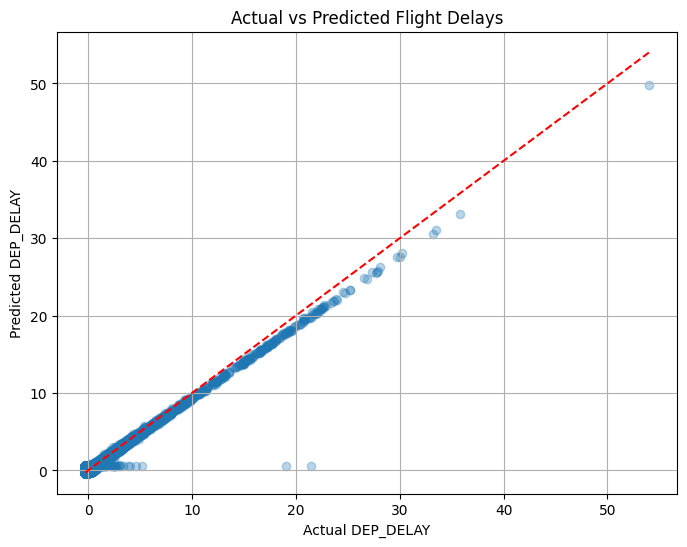

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual DEP_DELAY")
plt.ylabel("Predicted DEP_DELAY")
plt.title("Actual vs Predicted Flight Delays")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Reference line
plt.grid(True)
plt.show()


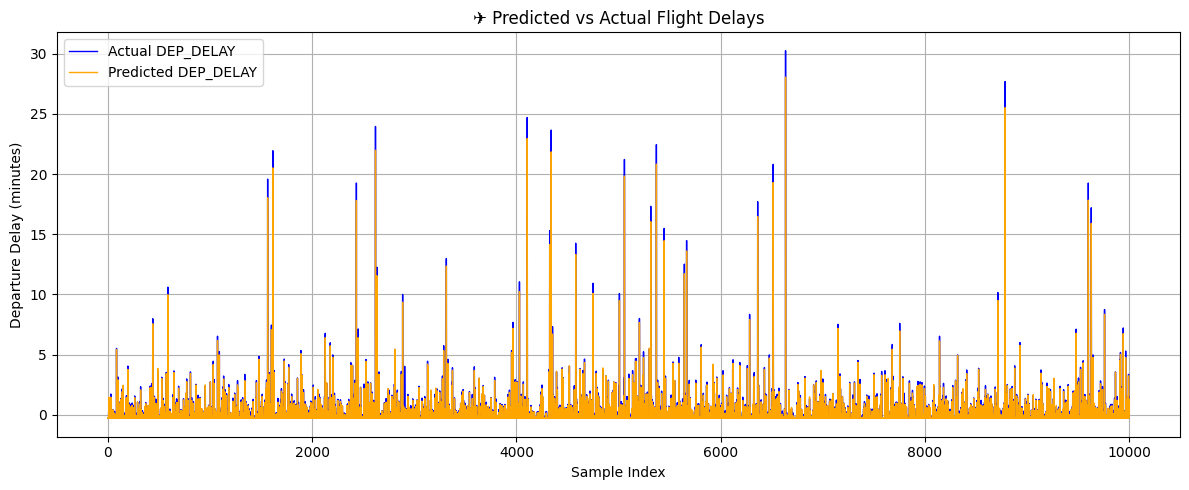

In [ ]:
import matplotlib.pyplot as plt

# If you haven’t predicted yet:
# y_pred = model.predict(X_test).flatten()

# Limit to first N samples for clarity (e.g., 10,000)
N = 10000
actual = y_test[:N].reset_index(drop=True)
predicted = pd.Series(y_pred[:N])

# Plot
plt.figure(figsize=(12, 5))
plt.plot(actual, label='Actual DEP_DELAY', color='blue', linewidth=1)
plt.plot(predicted, label='Predicted DEP_DELAY', color='orange', linewidth=1)
plt.title("✈ Predicted vs Actual Flight Delays")
plt.xlabel("Sample Index")
plt.ylabel("Departure Delay (minutes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


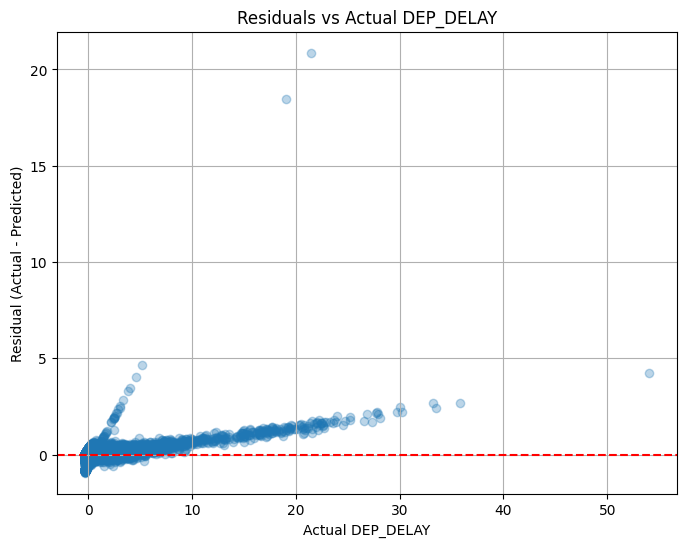

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure both are NumPy arrays
y_test_np = y_test.squeeze().to_numpy() if hasattr(y_test, 'to_numpy') else y_test
y_pred_np = y_pred.squeeze() if isinstance(y_pred, np.ndarray) else y_pred.detach().cpu().numpy()

# Compute residuals
residuals = y_test_np - y_pred_np

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_np, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual DEP_DELAY")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Actual DEP_DELAY")
plt.grid(True)
plt.show()


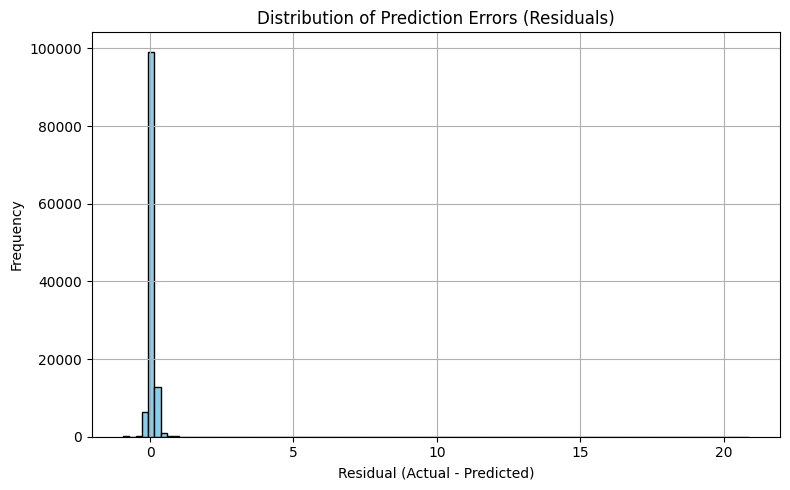

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to NumPy (if not already)
y_test_np = y_test.squeeze().to_numpy() if hasattr(y_test, 'to_numpy') else y_test
y_pred_np = y_pred.squeeze() if isinstance(y_pred, np.ndarray) else y_pred.detach().cpu().numpy()

# Calculate residuals
residuals = y_test_np - y_pred_np

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=100, color='skyblue', edgecolor='black')
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


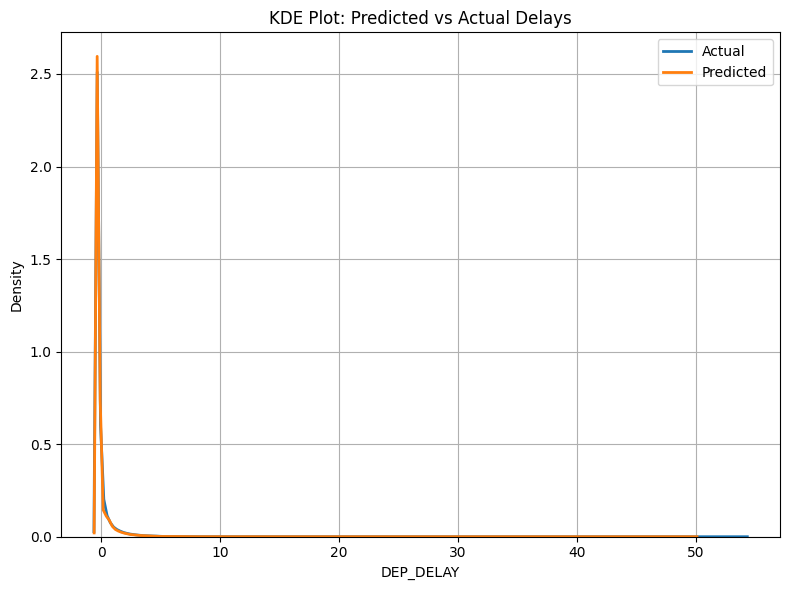

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy if needed
y_test_np = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test
y_pred_np = y_pred.detach().cpu().numpy() if hasattr(y_pred, 'detach') else y_pred

# KDE Plot
plt.figure(figsize=(8, 6))
sns.kdeplot(y_test_np.squeeze(), label="Actual", linewidth=2)
sns.kdeplot(y_pred_np.squeeze(), label="Predicted", linewidth=2)
plt.title("KDE Plot: Predicted vs Actual Delays")
plt.xlabel("DEP_DELAY")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
